# Understanding Dropout in Neural Networks: A Practical Tutorial on Regularisation and Generalisation

### 1. Import the required modules.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### 2. Load Fashion-MNIST and (optionally) keep only 3 classes

We’ll use tf.keras.datasets.fashion_mnist, and optionally restrict to 3 similar classes:
0 = T-shirt/top, 2 = Pullover, 4 = Coat

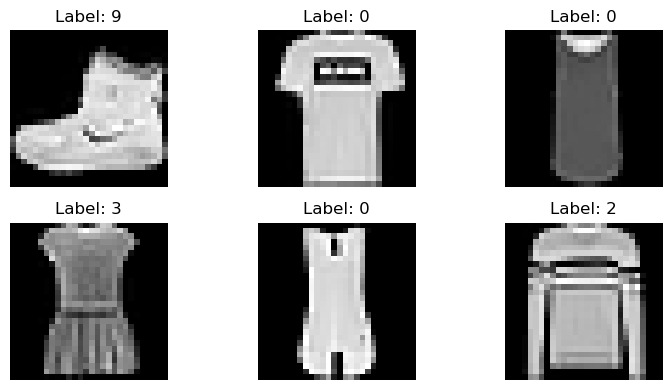

Original shapes: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
USE_CLASS_SUBSET = True   
CLASS_SUBSET = [0, 2, 4]  # which classes to keep if subset is on


# 1. Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Visualise a few examples from the dataset
plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Original shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

### Filter to subset.

In [7]:
if USE_CLASS_SUBSET:
    mask_train = np.isin(y_train, CLASS_SUBSET)
    mask_test = np.isin(y_test, CLASS_SUBSET)

    x_train = x_train[mask_train]
    y_train = y_train[mask_train]
    x_test = x_test[mask_test]
    y_test = y_test[mask_test]

    # remap class labels to 0..(num_classes-1)
    class_map = {c: i for i, c in enumerate(CLASS_SUBSET)}
    y_train = np.vectorize(class_map.get)(y_train)
    y_test = np.vectorize(class_map.get)(y_test)

num_classes = len(CLASS_SUBSET) if USE_CLASS_SUBSET else 10
print("After filtering:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("Number of classes:", num_classes)

After filtering: (18000, 28, 28) (18000,) (3000, 28, 28) (3000,)
Number of classes: 3


### 3. Normalise and create a validation split

We’ll scale pixels to [0, 1] and hold out some data for validation.

In [9]:
# Scale to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension (needed by Keras conv layers, but also fine for MLP)
x_train = np.expand_dims(x_train, -1)  # (N, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

# Make a validation set from training data
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)

Train: (14400, 28, 28, 1) Val: (3600, 28, 28, 1) Test: (3000, 28, 28, 1)


### 4. Build the models: with and without dropout

We’ll use a simple MLP (fully connected network) using Flatten + Dense:

Model A: no dropout

Model B: dropout (Dropout(rate=0.5)) after each hidden layer

4.1. Model without dropout

In [11]:
def build_mlp_no_dropout(num_classes):
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model_nodrop = build_mlp_no_dropout(num_classes)
model_nodrop.summary()

D:\Anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,523 (1.02 MB)

 Trainable params: 267,523 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2. Model with dropout

In [13]:
def build_mlp_with_dropout(num_classes, dropout_rate=0.5):
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

DROPOUT_RATE = 0.5
model_drop = build_mlp_with_dropout(num_classes, dropout_rate=DROPOUT_RATE)
model_drop.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,523 (1.02 MB)

 Trainable params: 267,523 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Train both models and log history

Hyperparameters:

In [15]:
BATCH_SIZE = 128
EPOCHS = 10

### 5.1. Train no-dropout model

In [17]:
history_nodrop = model_nodrop.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2
)

Epoch 1/10
113/113 - 1s - 13ms/step - accuracy: 0.8393 - loss: 0.4015 - val_accuracy: 0.8836 - val_loss: 0.3051
Epoch 2/10
113/113 - 0s - 4ms/step - accuracy: 0.8881 - loss: 0.2931 - val_accuracy: 0.8925 - val_loss: 0.2929
Epoch 3/10
113/113 - 0s - 4ms/step - accuracy: 0.8974 - loss: 0.2720 - val_accuracy: 0.9036 - val_loss: 0.2653
Epoch 4/10
113/113 - 0s - 4ms/step - accuracy: 0.9032 - loss: 0.2545 - val_accuracy: 0.9053 - val_loss: 0.2604
Epoch 5/10
113/113 - 0s - 4ms/step - accuracy: 0.9115 - loss: 0.2365 - val_accuracy: 0.9078 - val_loss: 0.2517
Epoch 6/10
113/113 - 0s - 4ms/step - accuracy: 0.9087 - loss: 0.2352 - val_accuracy: 0.8950 - val_loss: 0.2803
Epoch 7/10
113/113 - 0s - 4ms/step - accuracy: 0.9138 - loss: 0.2210 - val_accuracy: 0.9081 - val_loss: 0.2579
Epoch 8/10
113/113 - 1s - 4ms/step - accuracy: 0.9183 - loss: 0.2130 - val_accuracy: 0.9067 - val_loss: 0.2539
Epoch 9/10
113/113 - 1s - 5ms/step - accuracy: 0.9220 - loss: 0.2034 - val_accuracy: 0.9119 - val_loss: 0.2420


### 5.2. Train dropout model

In [19]:
history_drop = model_drop.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2
)

Epoch 1/10
113/113 - 1s - 13ms/step - accuracy: 0.7943 - loss: 0.4889 - val_accuracy: 0.8794 - val_loss: 0.3230
Epoch 2/10
113/113 - 1s - 5ms/step - accuracy: 0.8599 - loss: 0.3557 - val_accuracy: 0.8822 - val_loss: 0.3108
Epoch 3/10
113/113 - 1s - 4ms/step - accuracy: 0.8684 - loss: 0.3386 - val_accuracy: 0.8897 - val_loss: 0.2992
Epoch 4/10
113/113 - 1s - 5ms/step - accuracy: 0.8758 - loss: 0.3258 - val_accuracy: 0.8936 - val_loss: 0.2836
Epoch 5/10
113/113 - 1s - 6ms/step - accuracy: 0.8801 - loss: 0.3134 - val_accuracy: 0.8850 - val_loss: 0.2895
Epoch 6/10
113/113 - 1s - 5ms/step - accuracy: 0.8858 - loss: 0.3038 - val_accuracy: 0.8833 - val_loss: 0.2899
Epoch 7/10
113/113 - 1s - 5ms/step - accuracy: 0.8878 - loss: 0.2963 - val_accuracy: 0.8939 - val_loss: 0.2826
Epoch 8/10
113/113 - 1s - 5ms/step - accuracy: 0.8902 - loss: 0.2939 - val_accuracy: 0.8997 - val_loss: 0.2745
Epoch 9/10
113/113 - 1s - 6ms/step - accuracy: 0.8922 - loss: 0.2853 - val_accuracy: 0.8972 - val_loss: 0.2772


### 6. Plot training vs validation curves

These plots are gold for your report.

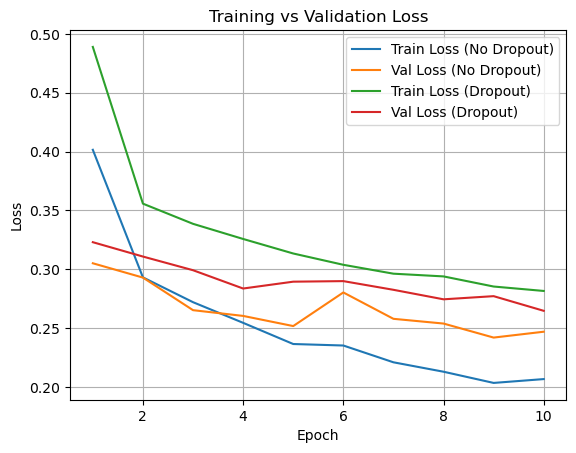

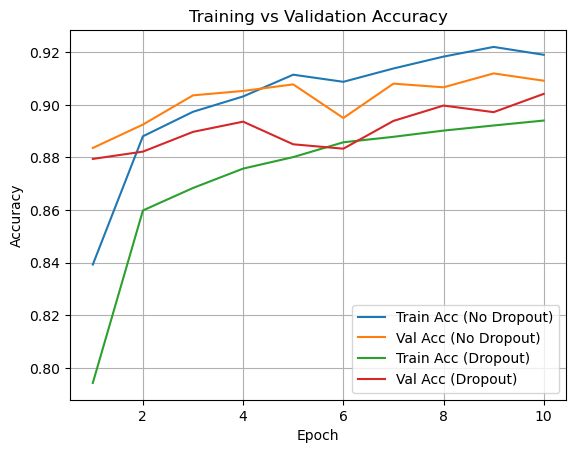

In [21]:
def plot_history(h1, h2, labels=("No Dropout", "Dropout")):
    epochs = range(1, len(h1.history["loss"]) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, h1.history["loss"], label=f"Train Loss ({labels[0]})")
    plt.plot(epochs, h1.history["val_loss"], label=f"Val Loss ({labels[0]})")
    plt.plot(epochs, h2.history["loss"], label=f"Train Loss ({labels[1]})")
    plt.plot(epochs, h2.history["val_loss"], label=f"Val Loss ({labels[1]})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("TrainvsValidationloss_ML1.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(epochs, h1.history["accuracy"], label=f"Train Acc ({labels[0]})")
    plt.plot(epochs, h1.history["val_accuracy"], label=f"Val Acc ({labels[0]})")
    plt.plot(epochs, h2.history["accuracy"], label=f"Train Acc ({labels[1]})")
    plt.plot(epochs, h2.history["val_accuracy"], label=f"Val Acc ({labels[1]})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("TrainvsValidationAccuracy_ML1.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_history(history_nodrop, history_drop)

### 7. Evaluate on the test set

In [23]:
test_loss_nodrop, test_acc_nodrop = model_nodrop.evaluate(x_test, y_test, verbose=0)
test_loss_drop, test_acc_drop = model_drop.evaluate(x_test, y_test, verbose=0)

print(f"No Dropout   - Test loss: {test_loss_nodrop:.4f}, Test acc: {test_acc_nodrop:.3f}")
print(f"Dropout={DROPOUT_RATE} - Test loss: {test_loss_drop:.4f}, Test acc: {test_acc_drop:.3f}")

No Dropout   - Test loss: 0.2767, Test acc: 0.895
Dropout=0.5 - Test loss: 0.2843, Test acc: 0.890
